<a href="https://colab.research.google.com/github/RazvanGolan/Faculty-3rd-year/blob/main/bia/lab4/BIA_Lab_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Decision trees

Let’s build a **decision tree** and take a look at how it makes predictions. The following code trains a `DecisionTreeClassifier` on the `iris` dataset, using only the petal length and petal width as features. The `max_depth` parameter specifies the maximum allowed depth of the tree.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris_dataset = load_iris()
X = iris_dataset.data[:, 2:] # petal length and width
y = iris_dataset.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=42)

We can visualize the trained decision tree by first using the `export_graphviz()` method to output a graph definition file called `iris_tree.dot`. Then we can use the `from_file` method of the `Source` class from the `graphviz` package to visualize this `.dot` file.

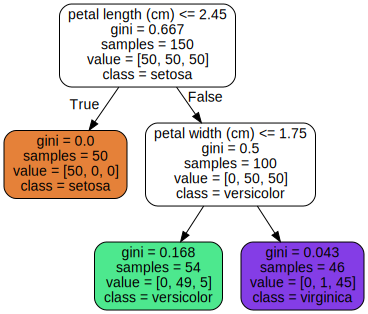

In [ ]:
import os
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(".", "iris_tree.dot"),
        feature_names=iris_dataset.feature_names[2:],
        class_names=iris_dataset.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(".", "iris_tree.dot"))

Let’s see how the tree represented above makes predictions. Suppose we find an iris flower and we want to classify it. We start at the *root node* (depth 0, at the top): this node asks whether the flower’s petal length is smaller than 2.45 cm. If it is, then we move down to the root’s left child node (depth 1, left). In this case, it is a *leaf node* (i.e., it does not have any child nodes), so it does not ask any questions: we simply look at the predicted class for that node, and the decision tree predicts that our flower is an *iris setosa* (`class=setosa`).

Now suppose we find another flower, and this time the petal length is greater than 2.45 cm. We must move down to the root’s right child node (depth 1, right), which is not a leaf node, so the node asks another question: is the petal width smaller than 1.75 cm? If it is, then our flower is most likely an *iris versicolor* (depth 2, left). If not, it is likely an *iris virginica* (depth 2, right).

A node’s `samples` attribute counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm (depth 1, right), and of those 100, 54 have a petal width smaller than 1.75 cm (depth 2, left). A node’s `value` attribute tells us how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 *iris setosa*, 1 *iris versicolor*, and 45 *iris virginica*. Finally, a node’s `gini` attribute measures its *impurity*: a node is *pure* (`gini=0`) if all training instances it applies to belong to the same class. For
example, since the depth-1 left node applies only to *iris setosa* training instances, it is pure and its `gini` score is 0. The depth-2 left node has a gini score equal to $1 – (0/54)^2 – (49/54)^2 – (5/54)^2 \approx 0.168$.

The figure below shows the decision tree’s *decision boundaries*. The thick vertical line represents the decision boundary of the root node (depth 0): petal length = 2.45 cm. Since the lefthand area is pure (only *iris setosa*), it cannot be split any further. However, the righthand area is impure, so the depth-1 right node splits it at petal width = 1.75 cm (represented by the dashed line). Since `max_depth` was set to 2, the decision tree stops right there. If we set `max_depth` to 3, then the two depth-2 nodes would each add another decision boundary (represented by the dotted lines).

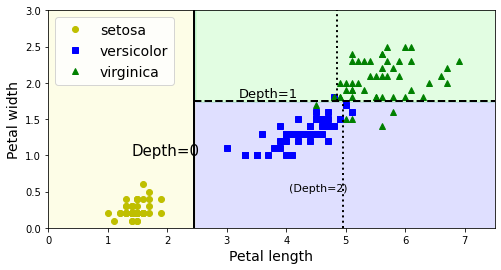

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3]):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="setosa")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="versicolor")
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="virginica")
    plt.axis(axes)
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    plt.legend(loc="upper left", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

plt.show()

A decision tree can also estimate the probability that an instance belongs to a particular class $k$. First, it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class $k$ in this node. For example, suppose we have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node, so the decision tree should output the following probabilities: $0\%$ for *iris setosa* ($0/54$), $90.7\%$ for *iris versicolor* ($49/54$), and $9.3\%$ for *iris virginica* ($5/54$).

In [ ]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

And if we ask it to predict the class, it should output *iris versicolor* (class 1) because it has the highest probability. Let’s check this:

In [ ]:
tree_clf.predict([[5, 1.5]])

array([1])

Notice that the estimated probabilities would be identical anywhere else in
the bottom-right rectangle of the above figure. For example, if the petals were 6 cm long and 1.5 cm wide (even though it seems obvious that it would most likely be an *iris virginica* in this case).

We have mentioned that small changes in the dataset may produce a very different decision tree. Let's now show that training the same model on the same data may produce a very different model every time, since the *CART* training algorithm used by `scikit-learn` is stochastic. To show this, we will set `random_state` to a different value than earlier:

In [ ]:
tree_clf_tweaked = DecisionTreeClassifier(max_depth=2, random_state=40)
tree_clf_tweaked.fit(X, y)

DecisionTreeClassifier(max_depth=2, random_state=40)

We can see that the decision boundaries look quite different.

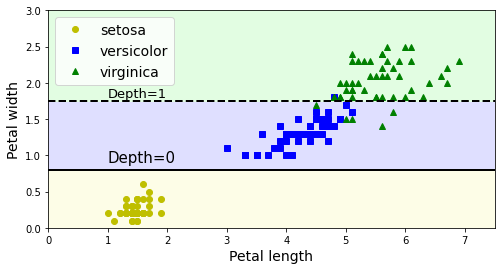

In [ ]:
plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf_tweaked, X, y)
plt.plot([0, 7.5], [0.8, 0.8], "k-", linewidth=2)
plt.plot([0, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.text(1.0, 0.9, "Depth=0", fontsize=15)
plt.text(1.0, 1.80, "Depth=1", fontsize=13)

plt.show()

To avoid overfitting the training data, we need to restrict the decision tree’s freedom during training. As we know by now, this is called *regularization*. The regularization hyperparameters depend on the algorithm used, but generally we can at least restrict the maximum depth of the decision tree. In `scikit-learn`, this is controlled by the `max_depth` hyperparameter (the default value is `None`, which means unlimited). Reducing `max_depth` will regularize the model and thus reduce the risk of overfitting.

The `DecisionTreeClassifier` class has a few other parameters that similarly restrict the shape of the decision tree: `min_samples_split` (the minimum number of samples a node must have before it can be split), `min_samples_leaf` (the minimum number of samples a leaf node must have), `min_weight_fraction_leaf` (same as `min_samples_leaf` but expressed as a fraction of the total number of weighted instances), `max_leaf_nodes` (the maximum number of leaf nodes), and `max_features` (the maximum number of features that are evaluated for splitting at each node). Increasing `min_*` hyperparameters or reducing `max_*` hyperparameters will regularize the model.

The figure below shows two decision trees trained on the `two_moons` dataset. On the left, the decision tree is trained with the default hyperparameters (i.e., no restrictions), and on the right it’s trained with `min_samples_leaf=4`. It is quite obvious that the model on the left is overfitting, and the model on the right will probably generalize better.

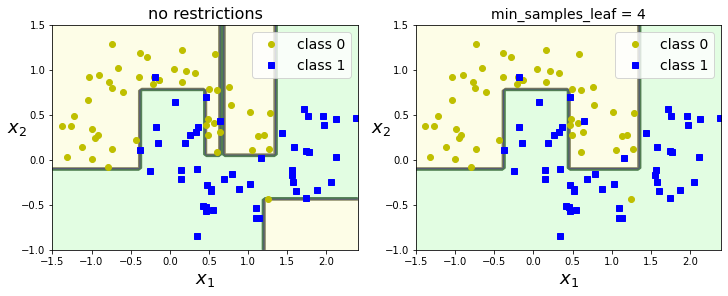

In [ ]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.4, -1, 1.5]):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="class 0")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="class 1")
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    plt.legend(loc="upper right", fontsize=14)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), constrained_layout=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym)
plt.title("no restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.show()

Decision trees are also capable of performing **regression** tasks. Let’s build a regression tree using `scikit-learn`’s `DecisionTreeRegressor` class, training it on a noisy quadratic dataset with `max_depth=2`.

In [ ]:
# Quadratic training set + noise
np.random.seed(42)
n = 200
X = np.random.rand(n, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(n, 1) / 10

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

The resulting tree is represented in the figure below.

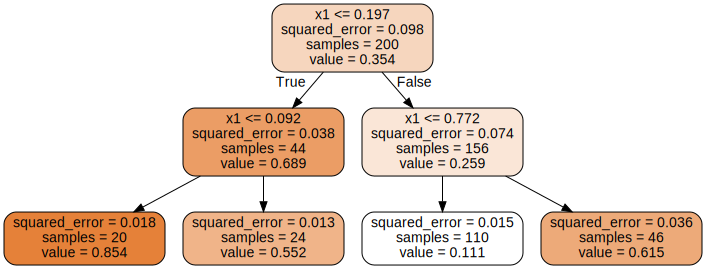

In [ ]:
export_graphviz(
        tree_reg,
        out_file=os.path.join(".", "regression_tree.dot"),
        feature_names=["x1"],
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(".", "regression_tree.dot"))

This tree looks very similar to the classification tree we built earlier. The main difference is that, instead of predicting a class in each node, it predicts a value. For example, suppose we want to make a prediction for a new instance with $x_1 = 0.6$. We traverse the tree starting at the root, and we eventually reach the leaf node that predicts `value=0.111`. This prediction is the average target value of the 110 training instances associated with this leaf node, and it results in a mean squared error equal to $0.015$ over these 110 instances.

This model’s predictions are represented on the left of the figure below. If we set `max_depth=3`, we get the predictions represented on the right. Notice how the predicted value for each region is always the average target value of the instances in that region. The algorithm splits each region in a way that makes most training instances as close as possible to that predicted value.

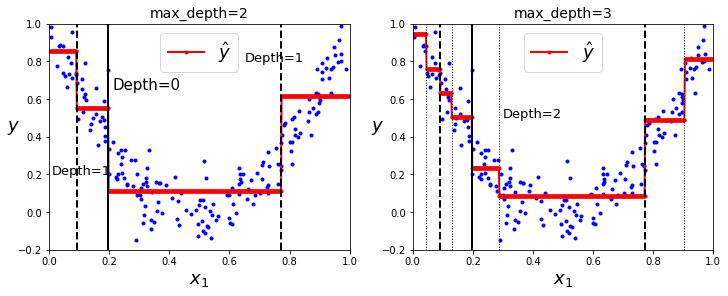

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(random_state=42, max_depth=2)
tree_reg2 = DecisionTreeRegressor(random_state=42, max_depth=3)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

def plot_regression_predictions(tree_reg, X, y, axes=[0, 1, -0.2, 1]):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$y$", fontsize=18, rotation=0)
    plt.plot(X, y, "b.")
    plt.plot(x1, y_pred, "r.-", linewidth=2, label=r"$\hat{y}$")

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), constrained_layout=True)
plt.sca(axes[0])
plot_regression_predictions(tree_reg1, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
plt.text(0.21, 0.65, "Depth=0", fontsize=15)
plt.text(0.01, 0.2, "Depth=1", fontsize=13)
plt.text(0.65, 0.8, "Depth=1", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=2", fontsize=14)

plt.sca(axes[1])
plot_regression_predictions(tree_reg2, X, y)
for split, style in ((0.1973, "k-"), (0.0917, "k--"), (0.7718, "k--")):
    plt.plot([split, split], [-0.2, 1], style, linewidth=2)
for split in (0.0458, 0.1298, 0.2873, 0.9040):
    plt.plot([split, split], [-0.2, 1], "k:", linewidth=1)
plt.text(0.3, 0.5, "Depth=2", fontsize=13)
plt.legend(loc="upper center", fontsize=18)
plt.title("max_depth=3", fontsize=14)

plt.show()

Just like for classification tasks, decision trees are prone to overfitting when dealing with regression tasks. Without any regularization (i.e., using the default hyperparameters), we get the predictions on the left in the figure below. These predictions are obviously overfitting the training set very badly. Just setting `min_samples_leaf=10` results in a much more reasonable model, represented on the right in the figure below.

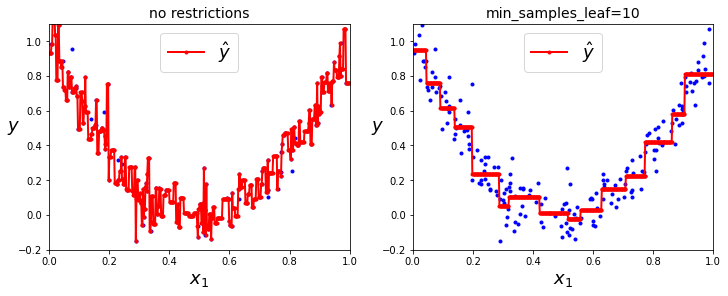

In [ ]:
tree_reg1 = DecisionTreeRegressor(random_state=42)
tree_reg2 = DecisionTreeRegressor(random_state=42, min_samples_leaf=10)
tree_reg1.fit(X, y)
tree_reg2.fit(X, y)

x1 = np.linspace(0, 1, 500).reshape(-1, 1)
y_pred1 = tree_reg1.predict(x1)
y_pred2 = tree_reg2.predict(x1)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), constrained_layout=True)

plt.sca(axes[0])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred1, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("no restrictions", fontsize=14)

plt.sca(axes[1])
plt.plot(X, y, "b.")
plt.plot(x1, y_pred2, "r.-", linewidth=2, label=r"$\hat{y}$")
plt.axis([0, 1, -0.2, 1.1])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", fontsize=18, rotation=0)
plt.legend(loc="upper center", fontsize=18)
plt.title("min_samples_leaf={}".format(tree_reg2.min_samples_leaf), fontsize=14)

plt.show()

#Voting

We can create a **voting classifier** in `scikit-learn` using the `VotingClassifier` class. It will be composed of
three diverse classifiers: logistic regression classifier, random forest classifier, and SVM classifier. They are given in the `estimators` parameter of the `VotingClassifier` class. We aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier
is a **hard voting** classifier, and we specify this using the `voting='hard'` parameter. We train the hard voting classifier on the `two_moons` dataset.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

Let’s look at each classifier’s accuracy on the test set.

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


We can see that the voting classifier slightly outperforms all the individual
classifiers, having an accuracy of $91.2\%$.

If all classifiers are able to estimate class probabilities (i.e., they all have a `predict_proba()` method), then we can tell `scikit-learn` to predict the class with the highest class probability, averaged over all the individual classifiers. This is called **soft voting**. It often achieves higher performance than hard voting, because it gives more weight to highly confident votes. All we need to do is replace `voting='hard'` with `voting='soft'` and ensure that all classifiers can estimate class probabilities. This is not the case for the `SVC` class by default, so we need to set its `probability` hyperparameter to `True` (this will make the `SVC` class use cross-validation to estimate class probabilities, slowing down training, and it will add a `predict_proba()` method). If we modify the preceding code to use soft voting, we will find that the voting classifier achieves $92\%$ accuracy.

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


#Bagging and pasting

`scikit-learn` offers a simple API for both **bagging** and **pasting** with the `BaggingClassifier` class (or `BaggingRegressor` for regression). The following code trains an ensemble of 500 decision tree classifiers: each is trained on 100 training instances randomly sampled from the training set with replacement (this is an example of bagging, but if we want to use pasting instead, we can just set `bootstrap=False`). The `n_jobs` parameter tells `scikit-learn` the number of CPU cores to use for training and predictions (`–1` tells Scikit-Learn to use all available cores).

The `BaggingClassifier` automatically performs *soft voting* instead of hard voting, if the base classifier can estimate class probabilities (i.e., if it has a `predict_proba()` method), which is the case with decision tree classifiers.

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

The bagging classifier of 500 decision trees achieves a test set accuracy of $90.4\%$.

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


Instead, one decision tree classifier has only $85.6\%$ accuracy on the test set.

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


The figure below compares the *decision boundary* of a single decision tree with the *decision boundary* of a bagging ensemble of 500 trees (from the preceding code), both trained on the `two_moons` dataset. As we can see, the ensemble’s predictions will likely generalize much better than the single decision tree’s predictions: the ensemble has a comparable bias but a smaller variance (it makes roughly the same number of errors on the training set, but the decision boundary is less irregular).

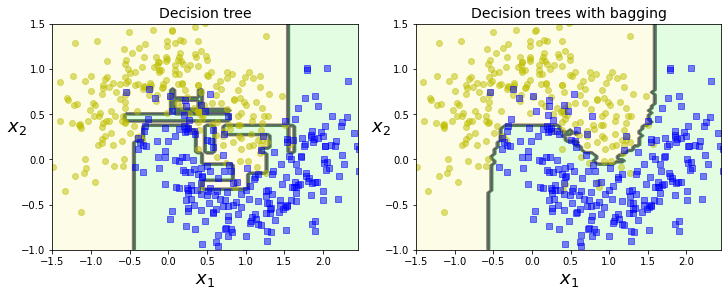

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), constrained_layout=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision trees with bagging", fontsize=14)
plt.show()

With bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. By default, a `BaggingClassifier` samples $n$ training instances with replacement (`bootstrap=True`), where $n$ is the size of the training set. This means that only about $63\%$ of the training instances are sampled, on average, for each predictor. The remaining $37\%$ of the training instances that are not sampled are **out-of-bag** (**oob**) instances. Note that they are not the same $37\%$ for all predictors.

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set. We can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

In `scikit-learn`, we can set `oob_score=True` when creating a `BaggingClassifier` to request an automatic oob evaluation after training. The following code demonstrates this. The resulting evaluation score is available through the `oob_score_` variable.

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

According to this oob evaluation, this `BaggingClassifier` is likely to achieve about $89.8\%$ accuracy on the test set. Let’s verify this:

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

We get $91.2\%$ accuracy on the test set, which is close enough.

#Random forests

A **random forest** is an ensemble of decision trees, generally trained via the bagging method (or sometimes pasting), typically with `max_samples` set to the size of the training set. Instead of building a `BaggingClassifier` and passing
it a `DecisionTreeClassifier`, we can instead use the `RandomForestClassifier` class, which is more convenient and optimized for decision trees (similarly, there is a `RandomForestRegressor` class for regression tasks). The following code uses all available CPU cores to train a random forest classifier with 500 trees (each limited to maximum 16 leaf nodes).

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The random forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. The algorithm results in greater tree diversity, which trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`.

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

In [ ]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions

1.0

We can create an **extra-trees** classifier using `scikit-learn`’s `ExtraTreesClassifier` class. Its API is identical to the `RandomForestClassifier` class. Similarly, the `ExtraTreesRegressor` class has the same API as the `RandomForestRegressor` class.

Random forests make it easy to measure the relative **feature importances**. `scikit-learn` measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest). More precisely, it is a weighted average, where each node’s weight is equal to the number of training samples that are associated with it.

`scikit-learn` computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. We can access the result using the `feature_importances_` variable. For example, the following code trains a `RandomForestClassifier` on the `iris` dataset and outputs each feature’s importance. It seems that the most important features are the petal length ($44\%$) and width ($42\%$), while sepal length and width are rather unimportant in comparison ($11\%$ and $2\%$, respectively).

In [ ]:
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris_dataset["data"], iris_dataset["target"])
for name, score in zip(iris_dataset["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


We can also plot the feature importances using a bar graph.

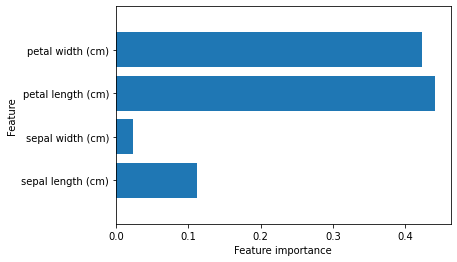

In [ ]:
def plot_feature_importances(model):
    n_features = iris_dataset.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), iris_dataset.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(rnd_clf)

#Boosting

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by **AdaBoost**.

For example, when training an AdaBoost classifier, the algorithm first trains a base classifier (such as a decision tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.

The figure below shows the decision boundaries of five consecutive predictors on the `two_moons` dataset (in this example, each predictor is a highly regularized SVM classifier with an RBF kernel). The first classifier gets many instances wrong, so their weights get boosted. The second classifier therefore does a better job on these instances, and so on. The plot on the right represents the same sequence of predictors, except that the learning rate is halved (i.e., the misclassified instance weights are boosted half as much at every iteration). As you can see, this sequential learning technique has some similarities with Gradient Descent, except that instead of tweaking a single predictor’s parameters to minimize a cost function, AdaBoost adds predictors to the ensemble, gradually making it better.

Once all predictors are trained, the ensemble makes predictions very much like bagging or pasting, except that predictors have different weights depending on their overall accuracy on the weighted training set.

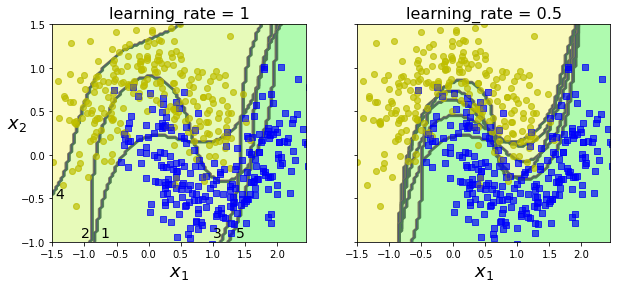

In [ ]:
n = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(n) / n
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * n)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum()
        alpha = learning_rate * np.log((1 - r) / r)
        sample_weights[y_pred != y_train] *= np.exp(alpha)
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

The following code trains an AdaBoost classifier based on 200 decision stumps using `scikit-learn`’s `AdaBoostClassifier` class (as we might expect, there is also an `AdaBoostRegressor` class). A decision stump is a decision tree with `max_depth=1`. In other words, a tree composed of a single decision node plus two leaf nodes. This is the default `base_estimator` for the `AdaBoostClassifier` class.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=200,
    learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

We can also plot the *decision boundary* of the AdaBoost classifier.

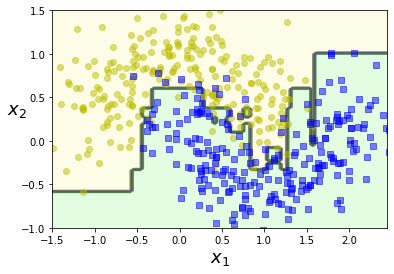

In [ ]:
plot_decision_boundary(ada_clf, X, y)

Just like AdaBoost, **gradient boosting** works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the *residual errors* made by the previous predictor.

Let’s go through a simple regression example, using decision trees as the base predictors (of course, gradient boosting also works great with regression tasks). This is called *gradient tree boosting*, or *gradient boosted regression trees* (*GBRT*). First, let’s fit a `DecisionTreeRegressor` to the training set, in our example, a noisy quadratic training set.

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Next, we will train a second `DecisionTreeRegressor` on the residual errors made by the first predictor.

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor.

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new
instance simply by adding up the predictions of all the trees.

In [ ]:
X_new = np.array([[0.8]])

In [ ]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right we can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of
the second tree. We can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

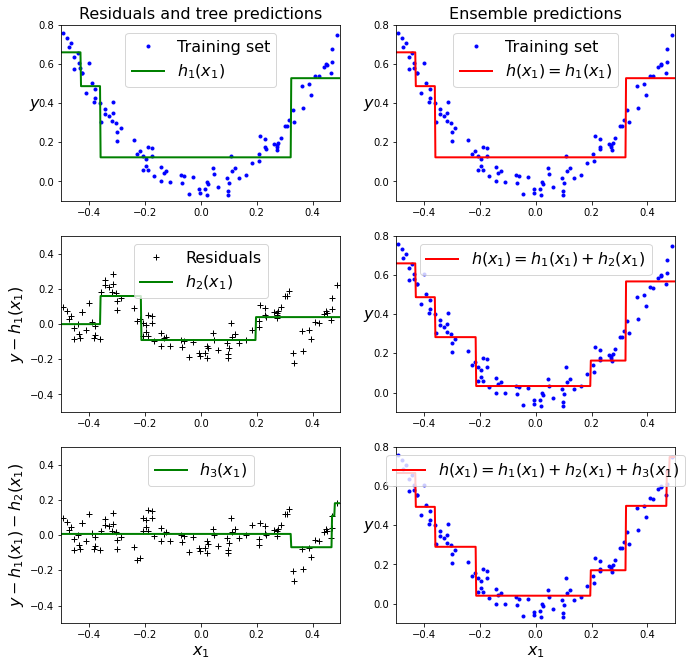

In [ ]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

A simpler way to train GBRT ensembles is to use `scikit-learn`’s `GradientBoostingRegressor` class. Much like the `RandomForestRegressor` class, it has hyperparameters to control the growth of decision trees (e.g., `max_depth`, `min_samples_leaf`), as well as hyperparameters to control the ensemble training, such as the number of trees (`n_estimators`). The following code creates the same ensemble as the previous one.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

The `learning_rate` hyperparameter scales the contribution of each tree. If we set it to a low value, such as 0.1, we will need more trees in the ensemble to fit the training set, but the predictions will usually generalize better. This is a regularization technique called *shrinkage*. The figure below shows two GBRT ensembles trained with a low learning rate: the one on the left does not have enough trees to fit the training set, while the one on the right has too many trees and overfits the training set.

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

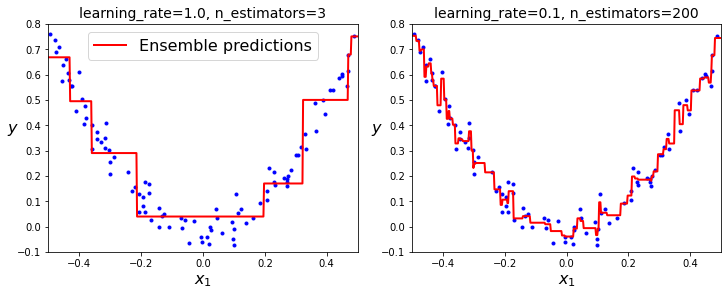

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), constrained_layout=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

In order to find the optimal number of trees, we can use **early stopping**. A simple way to implement this is to use the `staged_predict()` method: it returns an iterator over the predictions made by the ensemble at each stage of training (with one tree, two trees, etc.). The following code trains a GBRT ensemble with 120 trees, then measures the validation error at each stage of training to find the optimal number of trees, and finally trains another GBRT ensemble using the optimal number of trees.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

The validation errors are represented on the left of the figure below, and the best model’s predictions are represented on the right.

In [ ]:
min_error = np.min(errors)

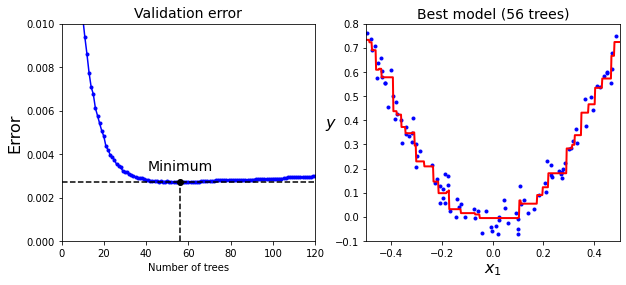

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

It is also possible to implement early stopping by actually stopping training early (instead of training a large number of trees first and then looking back to find the optimal number). We can do so by setting `warm_start=True`, which makes `scikit-learn` keep existing trees when the `fit()` method is called, allowing incremental training. The following code stops training when the validation error does not improve for five iterations in a row.

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

We can inspect the optimal number of decision trees.

In [ ]:
print(gbrt.n_estimators)

61


We can also print the minimum validation mean squared error.

In [ ]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463
